In [56]:
%pylab inline
import numpy as np
import cPickle as pickle
import seaborn as sns
from matplotlib.collections import LineCollection
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

sns.set_style('whitegrid')

Populating the interactive namespace from numpy and matplotlib


In [22]:
current_palette = sns.color_palette()
read_color = current_palette[0]
write_color = current_palette[1]

In [53]:
data = pickle.load(open("s3obj.ks_1000.txn.pickle", 'r'))
log = data['log']
keyspace_size = data['keyspace_size']
workers = data['workers']
txn_per_worker = data['txn_per_worker']
start_time = data['host_start_time']

In [ ]:
txn_times = np.zeros((workers, txn_per_worker, 2))
read_log = np.zeros((workers, txn_per_worker, 2))

job_times = np.zeros((workers, 2))
worker_clock_offsets = np.zeros(workers)

for worker_i, d in enumerate(log):
    for txn_i, txn in enumerate(d['runlog']):
        txn_times[worker_i, txn_i, 0] = txn['txn_start']
        txn_times[worker_i, txn_i, 1] = txn['txn_end']
        read_log[worker_i, txn_i, 0] = txn['read_id']
        read_log[worker_i, txn_i, 1] = txn['read_iter']
        
    job_times[worker_i, 0] = d['job_start']
    job_times[worker_i, 1] = d['job_end']
    mean_clock_offset = np.mean(d['timing_offsets'])
    worker_clock_offsets[worker_i] = mean_clock_offset
    # correct for timing shift
    txn_times[worker_i] += mean_clock_offset
    job_times[worker_i] += mean_clock_offset
txn_times -= start_time
job_times -= start_time

max_dur_sec = int(np.max(job_times))

runtime_bins = np.linspace(0, max_dur_sec, max_dur_sec*4)
runtime_bin_width = runtime_bins[1] - runtime_bins[0]

runtime_rate_hist = np.zeros((workers, len(runtime_bins)+1))


for worker_i in range(workers):
    for txn_i in range(txn_per_worker):
        
        s, e = txn_times[worker_i, txn_i]

        a, b = np.searchsorted(runtime_bins, [s, e])
        
        runtime_rate_hist[worker_i, b] += 1  #rate[i]
            #runtime_jobs_hist[i, a:b] = 1
runtime_rate_hist /= runtime_bin_width

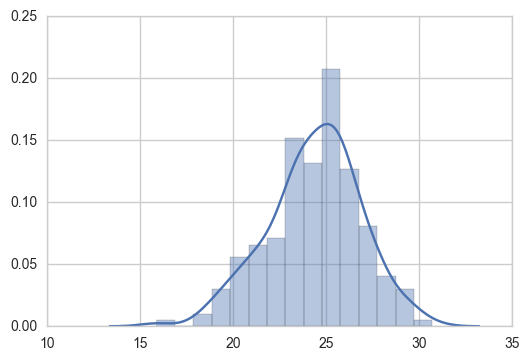

In [51]:
sns.distplot(txn_per_worker/(job_times[:, 1] - job_times[:, 0]))
pylab.xlabel("txn ")

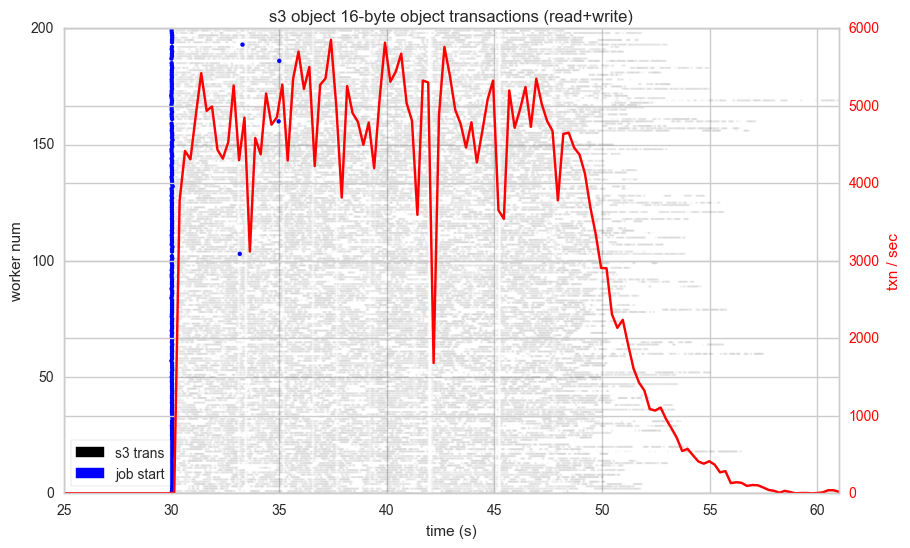

In [60]:
from matplotlib.collections import LineCollection

    
fig = pylab.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1,1)
for worker_i in range(workers):

   
    ax.scatter(txn_times[worker_i, :, 0], np.ones(txn_per_worker) * worker_i,
                edgecolor='none', s=3, c='k', alpha=0.03)

ax.scatter(job_times[:, 0], range(workers), c='b', edgecolor='none', s=10)
ax.set_ylim(0, workers)
ax.set_xlabel('time (s)')
ax.set_ylabel('worker num')


txn_patch = mpatches.Patch(color='k', label='s3 trans')
start_patch = mpatches.Patch(color='b', label='job start')

legend = pylab.legend(handles=[txn_patch, start_patch, ],
                      loc='lower left', frameon=True)

ax2 = ax.twinx()
ax2.plot(runtime_bins, runtime_rate_hist.sum(axis=0)[:-1], c='r')

ax2.set_ylabel('txn / sec', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
ax2.set_xlim(25, max_dur_sec)
ax.set_title("s3 object 16-byte object transactions (read+write)")

In [40]:
latency = []
write_time_of_read_data = np.zeros((workers, txn_per_worker))

for worker_i in range(workers):
    for txn_i in range(txn_per_worker):
        who_wrote_id = read_log[worker_i, txn_i, 0]
        their_iter = read_log[worker_i, txn_i, 1]
        #print who_wrote_id, their_iter
        if who_wrote_id < 0:
            txn_done_for_them = -1
        else:
            txn_done_for_them = txn_times[int(who_wrote_id), int(their_iter), 1]
        write_time_of_read_data[worker_i, txn_i] = txn_done_for_them

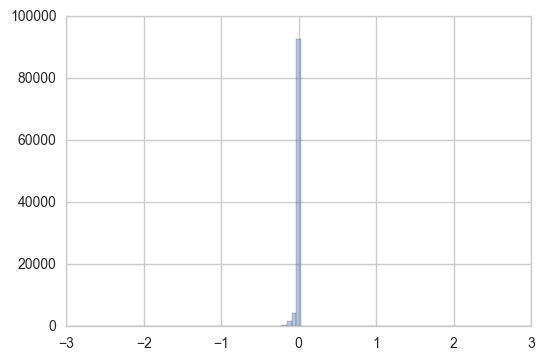

In [41]:
deltas = txn_times[:, :, 0] - write_time_of_read_data
sns.distplot(deltas[write_time_of_read_data > 0], kde=False, bins=np.linspace(-3, 3, 100))